## MNIST GAN

Este proyecto implementa una Red Generativa Advesaria para generar imagenes de numeros sobre el ya conocido MNIST Dataset.

Al final de este proyecto se quiere ver la evolucion de los numeros a traves de las iteraciones

<img src="https://wiki.pathmind.com/images/wiki/GANs.png" style="width: 50%">

In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as tt
import torch.nn as nn
import matplotlib.animation as animation

from datetime import datetime
from torchvision.transforms import ToTensor, Normalize
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid, save_image

## MNIST DATOS

Descargamos los datos y los normalizamos con valores entre -1 y 1

Tambien los cargamos en un data loader para separar las imagenes por lotes

In [2]:
# dataset = MNIST(root='MNIST-DATA/', download=True)

trans = tt.Compose( [ToTensor() , Normalize(0.5, 0.5, inplace=True)] )

train_dataset = MNIST(root='MNIST-DATA/', download=False, transform=trans)
valid_dataset = MNIST(root='MNIST-DATA/', train=False, transform=trans)  

C:\Users\David Gamaliel Arcos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(tensor(-1.), tensor(1.))


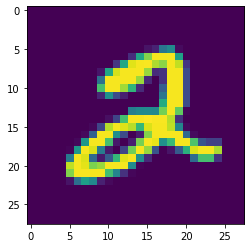

In [3]:
x, label = train_dataset[5]
pxl = torch.min(x), torch.max(x)
print(pxl)
plt.imshow(x.reshape(28,28,-1))

In [4]:
batch_size = 150

train_dl = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, drop_last=True) #, num_workers=2) 
valid_dl = DataLoader(dataset=valid_dataset, batch_size=batch_size)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

device

device(type='cpu')

## Generator Model

In [25]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size, device):
        super(Generator, self).__init__()
        self.device = device
        self.generator = nn.Sequential(
            nn.Linear(input_size,    hidden_size_1, device = device), nn.BatchNorm1d(hidden_size_1), nn.Dropout(0.25), nn.ReLU(inplace=True),
            nn.Linear(hidden_size_1, hidden_size_2, device = device), nn.BatchNorm1d(hidden_size_2), nn.Dropout(0.25), nn.ReLU(inplace=True),
            nn.Linear(hidden_size_2, hidden_size_3, device = device), nn.BatchNorm1d(hidden_size_3), nn.Dropout(0.25), nn.ReLU(inplace=True),
            nn.Linear(hidden_size_3, output_size  , device = device), 
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

## Discriminator Model

In [26]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, device):
        super(Discriminator, self).__init__()
        self.device = device
        self.discriminator = nn.Sequential(
            nn.Linear(input_size,    hidden_size_1, device = device), nn.Dropout(0.25), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size_1, hidden_size_2, device = device), nn.Dropout(0.25), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size_2, output_size  , device = device), 
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.discriminator(x)

## GAN Model

In [27]:
class GAN():

    def __init__(self, G, D, lr, train_dl, valid_dl, batch_size, G_input_size, D_input_size, device, rows, pxls):
        self.pxls = pxls
        self.device = device
        self.rows = rows
        self.batch_size = batch_size
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.G = G
        self.D = D
        self.G_input_size = G_input_size
        self.D_input_size = D_input_size
        self.lr = lr
        self.D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)
        self.G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
        self.G_loss = nn.BCELoss()
        self.D_loss = nn.BCELoss()
        self.samples = self.get_noise()

    def grad_reset(self):
        self.D_optimizer.zero_grad()
        self.G_optimizer.zero_grad()

    def G_train(self):
        # Genera vectores random
        noise = self.get_noise()
        # Genera imagenes 
        out = self.G(noise)
        # Label 0 para imagenes falsas
        # Pero usamos 1 para confundir a la red
        labels = torch.ones(batch_size, 1).to(self.device)
        # Calcular loss
        pred_labels = self.D(out)
        loss = self.G_loss(pred_labels, labels)
        # Reset gradientes
        self.grad_reset()
        # Calcular gradientes
        loss.backward()
        # Optimizar
        self.G_optimizer.step()
        return loss, out

    def D_train(self, images):
        # Genera vectores random
        noise = self.get_noise()
        # Label 1 para imagenes reales
        real_labels = torch.ones(batch_size, 1).to(self.device)
        # Label 0 para imagenes falsas
        fake_labels = torch.zeros(batch_size, 1).to(self.device)

        # Genera imagenes 
        out = self.G(noise)

        # Prediccion imagenes reales
        real_pred = self.D(images)
        # Prediccion imagenes fake
        fake_pred = self.D(out)

        # Calcular loss
        real_loss = self.D_loss(real_pred, real_labels)
        fake_loss = self.D_loss(fake_pred, fake_labels)

        # Sumar loss fn
        loss = real_loss + fake_loss
        # Reset gradientes
        self.grad_reset()
        # Calcular gradientes
        loss.backward()
        # Optimizar
        self.D_optimizer.step()
        return loss, real_pred, fake_pred
        
    def fit(self, its, folder="samples", saveLoss=False):
        torch.cuda.empty_cache()
        self.G_loss_it, self.D_loss_it = [], []
        self.real_pred_it, self.fake_pred_it = [], []
        begin_time = datetime.now()
        for it in range(its):
            batch_len = len(train_dl)
            for i, (images, labels) in enumerate(self.train_dl):
                
                self.G.train()
                self.D.train()

                images = images.reshape(batch_size, -1).to(self.device)
                
                loss_d, real_pred, fake_pred = self.D_train(images)
                loss_g, _ = self.G_train()
                
                if (i+1) % 100 == 0:
                    self.D_loss_it.append(loss_d.item())
                    self.G_loss_it.append(loss_g.item())
                    self.real_pred_it.append(real_pred.mean().item())
                    self.fake_pred_it.append(fake_pred.mean().item())
                    act_time = datetime.now()
                    print('Epoch[{}/{}]  Batch[{}/{}]  D_loss:{:.5f}  G_loss:{:.5f}  D(x)_mean:{:.5f}  D(G(p))_mean:{:.5f}  Time:{}'.format(
                        it+1, its, i+1, batch_len, loss_d.item(), loss_g.item(),
                        real_pred.mean().item(), fake_pred.mean().item(), act_time - begin_time
                    ))

            if saveLoss: self.plot_loss(save=True)
            self.save_image('sample_{0:0=4d}'.format(it), folder=folder)
            self.save_models()

        return
            
    def random_generator(self):
        random_vector = self.get_noise()
        out = self.G(random_vector)
        plt.imshow( out[0].detach().reshape(28,28,-1) )
        return out[0], self.D(out)[0]

    def show_samples(self, batch = False, show = True):
        out = self.G(self.samples).detach().reshape(-1,1,28,28) 
        if batch == True: out = self.take_random_batch()
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        grid = self.to_grid(out)
        if show: ax.imshow(grid) 
        return fig, ax, out
        
    def save_models(self, folder='models'):
        model_path = folder
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        torch.save(self.G.state_dict(), model_path+'/G.ckpt')
        torch.save(self.D.state_dict(), model_path+'/D.ckpt')

    def save_image(self, file_name, folder="samples", batch =False):
        samples_path = folder
        if not os.path.exists(samples_path):
            os.makedirs(samples_path)
        image = self.G(self.samples).detach().reshape(-1, 1, 28, 28)
        if batch == True: image = self.take_random_batch()
        save_image(image, os.path.join(samples_path, f'{file_name}.png'), nrow=self.rows)

    def take_random_batch(self):
        for images, labels in self.train_dl:
            return images
        return None

    def to_grid(self, images):
        return make_grid(images, nrow=self.rows).permute(1,2,0)

    def get_noise(self):
        return torch.tensor(np.random.uniform( -1., 1., #self.pxls[0],self.pxls[1],
            [self.batch_size, self.G_input_size]), dtype=torch.float32).to(self.device)

    def normalize(self, x):
        return (x + 1) / 2

    def plot_loss(self, save=False, file_name='loss-log', folder="loss"):
        plt.plot(self.D_loss_it, '-')
        plt.plot(self.G_loss_it, '-')
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Iteraciones')
        plt.ylabel('Loss')
        plt.title('Loss')
        if save:
            if not os.path.exists(folder):
                os.makedirs(folder)
            plt.savefig(os.path.join(folder, f'{file_name}.png'))
        else:
            plt.show()
    
    def plot_score(self):
        plt.plot(self.real_pred_it, '-')
        plt.plot(self.fake_pred_it, '-')
        plt.xlabel('Iteraciones')
        plt.ylabel('Score')
        plt.legend(['Real', 'Fake'])
        plt.title('Scores')


Al ser dos labels, imagen real o generada, usamos Binary Crossentropy Loss

<img src="http://androidkt.com/wp-content/uploads/2021/05/Selection_099-1024x200.png" style="width: 50%">

Asimismo usaremos ADAM como nuestro optimizador

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


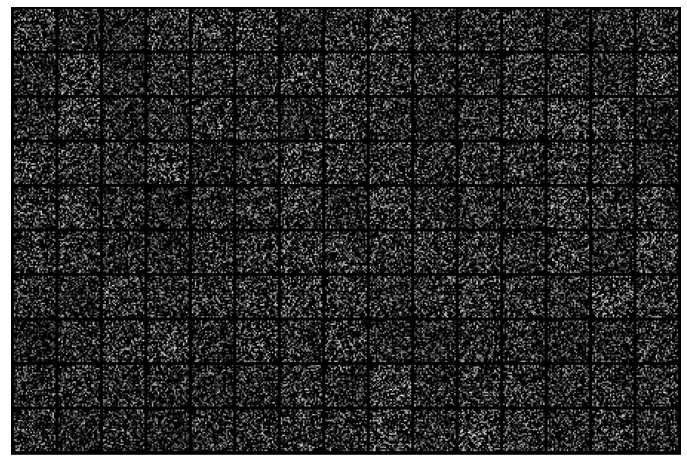

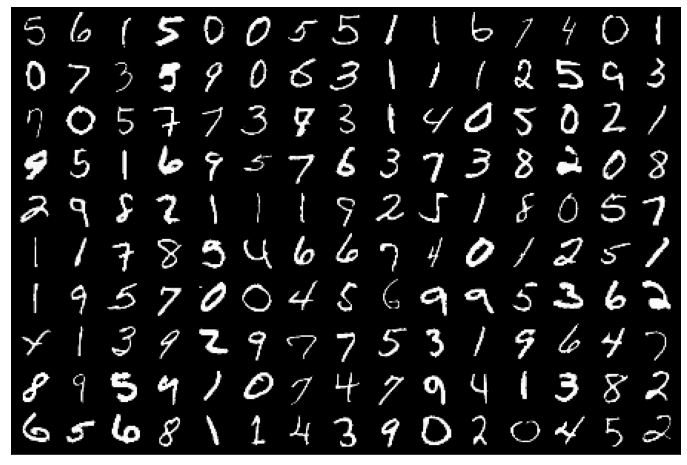

In [28]:
input_size    = 64
hidden_size_1 = 128
hidden_size_2 = 256
hidden_size_3 = 512
output_size   = 784

G = Generator(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size, device)
D = Discriminator(output_size, hidden_size_2, input_size, 1, device)

G.to(G.device)
D.to(D.device)

lr = 0.00005
pxls = (-1., 1.)

gan = GAN(G, D, lr, train_dl, valid_dl, batch_size, G_input_size=input_size, D_input_size=output_size, device=device, rows=15, pxls=pxls)

out = gan.show_samples()
out = gan.show_samples(batch=True)

# gan.save_image('test')
# gan.save_image('batch', batch=True)
# gan.save_models()

### Entrenamiento

Epoch[1/200]  Batch[100/400]  D_loss:1.13855  G_loss:0.60599  D(x)_mean:0.74322  D(G(p))_mean:0.56582  Time:0:00:06.631221
Epoch[1/200]  Batch[200/400]  D_loss:1.21307  G_loss:0.59543  D(x)_mean:0.71219  D(G(p))_mean:0.57614  Time:0:00:13.097922
Epoch[1/200]  Batch[300/400]  D_loss:1.07536  G_loss:0.73614  D(x)_mean:0.69641  D(G(p))_mean:0.50078  Time:0:00:20.802303
Epoch[1/200]  Batch[400/400]  D_loss:1.00613  G_loss:0.86115  D(x)_mean:0.71078  D(G(p))_mean:0.47127  Time:0:00:28.529626
Epoch[2/200]  Batch[100/400]  D_loss:0.88196  G_loss:1.05478  D(x)_mean:0.71308  D(G(p))_mean:0.40038  Time:0:00:39.366628
Epoch[2/200]  Batch[200/400]  D_loss:0.96876  G_loss:0.91902  D(x)_mean:0.68568  D(G(p))_mean:0.42832  Time:0:00:47.179721
Epoch[2/200]  Batch[300/400]  D_loss:1.34328  G_loss:0.71664  D(x)_mean:0.58717  D(G(p))_mean:0.53646  Time:0:00:54.939956
Epoch[2/200]  Batch[400/400]  D_loss:1.31675  G_loss:0.70341  D(x)_mean:0.60153  D(G(p))_mean:0.53326  Time:0:01:02.688223
Epoch[3/200]  Ba

<ipython-input-27-e2e0a3275c85>:163: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder, f'{file_name}.png'))


Epoch[74/200]  Batch[100/400]  D_loss:0.48335  G_loss:3.55617  D(x)_mean:0.85839  D(G(p))_mean:0.18545  Time:0:35:11.789513
Epoch[74/200]  Batch[200/400]  D_loss:0.35276  G_loss:4.45357  D(x)_mean:0.91106  D(G(p))_mean:0.13860  Time:0:35:18.368295
Epoch[74/200]  Batch[300/400]  D_loss:0.36933  G_loss:4.66005  D(x)_mean:0.86236  D(G(p))_mean:0.12230  Time:0:35:24.965642
Epoch[74/200]  Batch[400/400]  D_loss:0.30603  G_loss:4.60487  D(x)_mean:0.88440  D(G(p))_mean:0.10669  Time:0:35:31.579983
Epoch[75/200]  Batch[100/400]  D_loss:0.46692  G_loss:3.30061  D(x)_mean:0.87402  D(G(p))_mean:0.17385  Time:0:35:38.551290
Epoch[75/200]  Batch[200/400]  D_loss:0.31628  G_loss:3.69704  D(x)_mean:0.94054  D(G(p))_mean:0.15618  Time:0:35:45.104755
Epoch[75/200]  Batch[300/400]  D_loss:0.37149  G_loss:4.01914  D(x)_mean:0.87045  D(G(p))_mean:0.12982  Time:0:35:51.653268
Epoch[75/200]  Batch[400/400]  D_loss:0.69812  G_loss:3.27307  D(x)_mean:0.72504  D(G(p))_mean:0.14956  Time:0:35:58.150708
Epoch[76

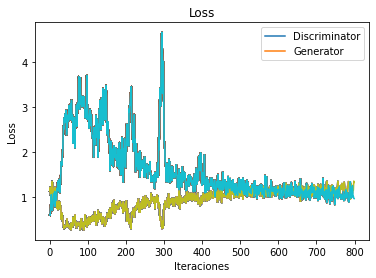

In [29]:
%%time
gan.fit(200, folder="samples", saveLoss=True)

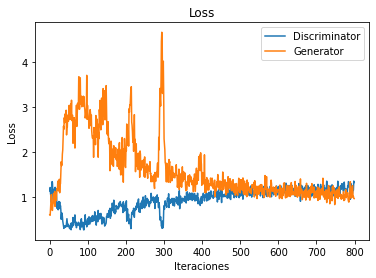

In [30]:
gan.plot_loss()

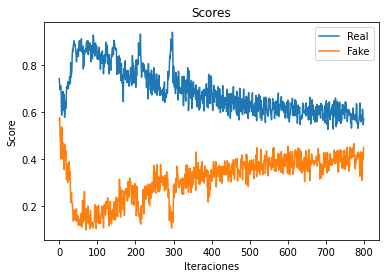

In [31]:
gan.plot_score()

## Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


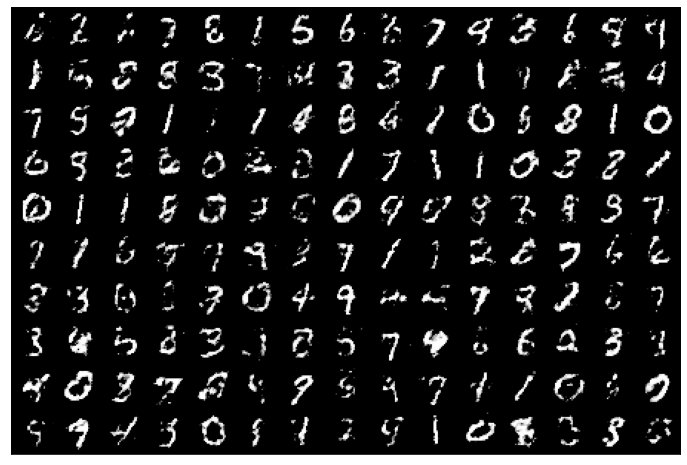

In [32]:
out = gan.show_samples()

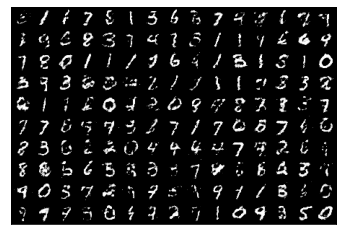

In [33]:
imgs = []
path = 'samples/'
lis = os.listdir(path)

fig, ax = plt.subplots()

ax.set_xticks([]), ax.set_yticks([])

for i, x in enumerate(lis):
    imgs.append([ax.imshow(plt.imread(path+x, format="png"), animated=True)])
    if i == 0: ax.imshow(plt.imread(path+x, format="png"))

ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True, repeat_delay=1000)

ani.save("sample-video.mp4")